models

- model_v3_patch_v5.h5 : it passes simple.

In [1]:
%matplotlib inline

import csv, random, numpy as np
from keras.models import load_model, Sequential,model_from_json
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Cropping2D
from keras.preprocessing.image import img_to_array, load_img, flip_axis, random_shift
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2, activity_l2
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from math import floor

import cv2
from PIL import Image
import json
import matplotlib.pyplot as plt

Using TensorFlow backend.


Define Model Architecture
adam optimizer configuration is default on Keras document.

In [2]:
def model(load, shape, lr = 0.001, checkpoint=None):
    """Return a model from file or to train on."""
    
   
    
    if load and checkpoint: return load_model(checkpoint)

#    conv_layers1, conv_layers2, dense_layers = [24, 36, 48], [64, 64], [1024, 512]
    dense_layers = [1024, 512]
    
    model = Sequential()
    
    model.add(Cropping2D(cropping=((40,20), (20,20)), input_shape=shape))
    model.add(Lambda(lambda x: x / 255.0 - 0.5))

    model.add(Convolution2D(24,5, 5,  border_mode = 'same',subsample=(1, 1)))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
     
    model.add(Convolution2D(32,5, 5,  border_mode = 'same', subsample=(1, 1),activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

   
    model.add(Convolution2D(48,3, 3, border_mode = 'same', subsample=(1, 1),activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Convolution2D(64, 3, 3,  border_mode = 'same', subsample=(1, 1), activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Flatten())
    for dl in dense_layers:
        model.add(Dense(dl, activation='elu'))
        model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    
    
    
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    model.compile(loss='mse', optimizer=adam)
    
    print("adam optimizer, lr is %s" % lr)
    
    return model

Data
- udacity_dir : data udacity provides for the project
- patch : recovery data for the problem part of track1 on left turn. recored on window
- t1_re : recovery data for the problem part of track1 on left turn. recored on linux
- t1_rer : recovery data for the problem part of track1  on reverse, right, turn. recored on linux

In [3]:
udacity_dir = ('../data2/driving_log.csv','linux','left')
patch=('../model3_patch3/driving_log.csv','window','re_left')
t1_re=('../t1_re/driving_log.csv','linux','re_right')
t1_rer=('../t1_rer/driving_log.csv','linux','re_right')
#t1_ce=('../t1_ce/driving_log.csv','linux','left')
#t1_rce=('../t1_rce/driving_log.csv','linux','left')

Define how to downsample 
Define steering angle offset for left and right side camera images.
- 0.35

In [4]:
#time_series = ['2016_11_22_14_59_16','2016_11_22_14_59_17','2016_11_22_14_59_18', '2016_11_22_14_59_19', '2016_11_22_14_59_20']
#time_series_t1_ce = ['2016_11_22_14_57_50','2016_11_22_14_57_51',
#               '2016_11_22_14_57_52', '2016_11_22_14_57_53', 
#               '2016_11_22_14_57_54', '2016_11_22_14_57_55']

time_series_t1_re = ['2016_11_22_19_48_32','2016_11_22_19_48_33',
               '2016_11_22_19_48_34', '2016_11_22_19_48_35', 
               '2016_11_22_19_48_36']

time_series_t1_rer = ['2016_11_22_19_52_26','2016_11_22_19_52_27',
               '2016_11_22_19_52_28']

time_series_patch = ['2017_04_12_21_19_10','2017_04_12_21_19_14',
                     '2017_04_12_21_19_16', '2017_04_12_21_19_21',
                    '2017_04_12_21_19_24', '2017_04_12_21_19_28']
             


def get_X_y_test(labels, time_series, device='linux', desc='left', ):
  
    X, y = [], []
    base = []

    steering_offset = 0.35
    with open(labels) as fin:
        for center_img, left_img, right_img, steering_angle, _, _, speed in csv.reader(fin):
            
                     
            if(device == "window"):
                    left_img = left_img.split('\\')[-1]
                    right_img = right_img.split('\\')[-1]
                    center_img = center_img.split('\\')[-1]
                        
            if(device == "linux"):         
                    left_img = left_img.split('/')[-1]
                    right_img = right_img.split('/')[-1]
                    center_img = center_img.split('/')[-1]
                        
            if(desc == 're_left'):
                
                 for index in range(len(time_series)):    
                    if(time_series[index] in left_img or time_series[index] in right_img
                       or time_series[index] in center_img):
                                   
                            X += [left_img.strip()]
                            y += [(float(steering_angle) + steering_offset) * 0.2]
              

                            X += [right_img.strip()]
                            y += [(float(steering_angle) - steering_offset)*0.2]
                        
                     
                            X += [center_img.strip()]
                            y += [(float(steering_angle))*0.2]
                        
                    
                            shuffle(X, y)
               
            else:
                for index in range(len(time_series)):    
                    if(time_series[index] in left_img or time_series[index] in right_img
                       or time_series[index] in center_img):
                                    
                            X += [left_img.strip()]
                            y += [float(steering_angle) + steering_offset]
              

                            X += [right_img.strip()]
                            y += [float(steering_angle) - steering_offset]
                        
                     
                            X += [center_img.strip()]
                            y += [float(steering_angle)]
                        
                    
                            shuffle(X, y)
                                 
    return X, y

In [5]:
def merge_data(dir1,time_series):

    X1, y1 = get_X_y_test(dir1[0], time_series, device=dir1[1], desc=dir1[2])
    
    X = X1
    y =  y1 
    
    return X,y

subsampling data.

315
315
0.0501919511619


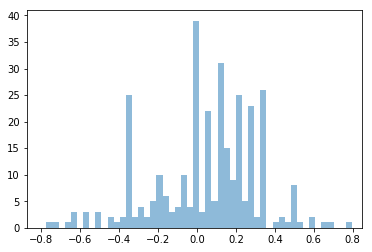

In [6]:
data_dir1 = t1_re
data_dir2 = t1_rer
data_dir3 = patch

X_raw1, y_raw1 = merge_data(data_dir1, time_series = time_series_t1_re)
X_raw2, y_raw2 = merge_data(data_dir2, time_series =time_series_t1_rer)
X_raw3, y_raw3 = merge_data(data_dir3, time_series =time_series_patch)

X_raw = X_raw1 + X_raw2 + X_raw3
y_raw = y_raw1 + y_raw2 + y_raw3
    
plt.xlim([min(y_raw)-0.1, max(y_raw)+0.05])

plt.hist(np.array(y_raw), alpha=0.5, bins=50)
#plt.plot(y_merge)

print(len(y_raw))
print(len(X_raw))

print(np.mean(np.array(y_raw)))

Normalize data distribution
- np.mean(angles) : -0.00143245576786

11.5


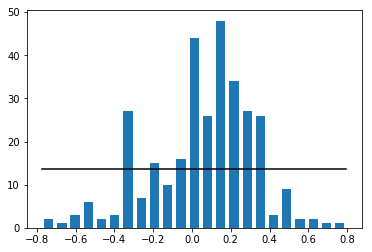

In [7]:
angles = np.array(y_raw)
num_bins = 23
avg_samples_per_bin = len(angles)/num_bins
hist, bins = np.histogram(angles, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')


print(num_bins/2)

In [8]:
keep_probs = []
target = avg_samples_per_bin * 4.0
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
        
remove_list = []
for i in range(len(angles)):
    for j in range(num_bins):
        if angles[i] > bins[j] and angles[i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            
            if j > (num_bins/2 - 4.5) and j < (num_bins/2 + 4.5):
                
                if np.random.rand() > (keep_probs[j] * 0.1) :
                    
                    remove_list.append(i)
            
            else:
            
                if np.random.rand() > keep_probs[j]:
                    remove_list.append(i)
       
            
                
print(keep_probs)
print(hist)
print(avg_samples_per_bin)
print(hist[9]/(0.5*avg_samples_per_bin))
print(1./(hist[9]/(0.5*avg_samples_per_bin)))
#image_paths = np.delete(image_paths, remove_list, axis=0)
#angles = np.delete(angles, remove_list)

angles = np.delete(angles, remove_list)


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[ 2  1  3  6  2  3 27  7 15 10 16 44 26 48 34 27 26  3  9  2  2  1  1]
13.695652173913043
1.46031746032
0.684782608696


https://github.com/jeremy-shannon/CarND-Behavioral-Cloning-Project/blob/master/model.py

-0.00438951568067


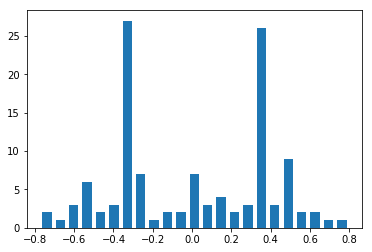

In [9]:
num_bins = 23

hist, bins = np.histogram(angles, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)


print(np.mean(angles))

In [10]:
y_merge = angles.tolist()

images = np.array(X_raw)
X_merge = np.delete(images, remove_list)
X_merge = X_merge.tolist()

print(y_merge)
print(X_merge)

[0.35, -0.35, -0.5601414, -0.5601414, -0.5601414, -0.5045527, 0.35, -0.35, 0.35, -0.35, 0.35, -0.35, 0.35, -0.35, 0.35, -0.35, 0.35, -0.35, 0.35, -0.35, 0.42116971, -0.27883029, 0.4952879, 0.1452879, 0.5138175, -0.18618249999999997, 0.532347, 0.35631625299999997, -0.343683747, 0.35631625299999997, -0.343683747, 0.35631625299999997, -0.343683747, 0.35631625299999997, -0.343683747, 0.35, -0.35, 0.35, -0.35, 0.35, -0.35, 0.5833033, 0.472126, -0.22787399999999997, 0.35, -0.35, 0.35, -0.35, 0.35, -0.35, -0.38874297999999996, -0.43506685999999994, -0.5045527, -0.5045527, 0.35, -0.35, 0.35, -0.35, 0.35, -0.35, 0.35, -0.35, -0.6342596, -0.2842596, -0.6342596, -0.2842596, 0.35, -0.35, 0.0, 0.6018328, 0.6944806, 0.3444806, 0.7963932, 0.4463932, 0.6574215, -0.4582288, -0.1082288, -0.7315396999999999, -0.3815397, -0.7732311999999999, -0.4232312, 0.39337535999999995, -0.30662464, 0.5045527, 0.5045527, 0.5045527, 0.5045527, 0.5045527, 0.5045527, 0.35, -0.35, 0.0, -0.6342596, -0.2842596, -0.6620539, 

Data augmentation
- random_darken
- horizontal and vertical shift
- horizontal flip

In [11]:
def random_darken(image):
    """Given an image (from Image.open), randomly darken a part of it."""
    w, h = image.size

    # Make a random box.
    x1, y1 = random.randint(0, w), random.randint(0, h)
    x2, y2 = random.randint(x1, w), random.randint(y1, h)

    # Loop through every pixel of our box (*GASP*) and darken.
    for i in range(x1, x2):
        for j in range(y1, y2):
            new_value = tuple([int(x * 0.5) for x in image.getpixel((i, j))])
            image.putpixel((i, j), new_value)
    return image

In [12]:
def split_data(data, label, split = 0.3):
    
    train_samples, validation_samples, train_labels, validation_labels = train_test_split(
    data,
    label,
    test_size=split,
    random_state=832289)
    
    return train_samples, validation_samples, train_labels, validation_labels

In [13]:
def process_image_test(image, steering_angle, augment=True, shape=(160,320)):
    """Process and augment an image."""

    pil_image = Image.fromarray(image)

    if augment and random.random() < 0.5:
        pil_image = random_darken(pil_image)  # before numpy'd

    image = img_to_array(pil_image)
      
    
    if augment:
        image = random_shift(image, 0.05, 0.4, 0, 1, 2)  # only vertical
        if random.random() < 0.5:
            image = flip_axis(image, 1)
            steering_angle = -steering_angle
      
    return image, steering_angle

Define generator 

- generator : train generator
- generator_valid : validation generator

In [14]:
# image directory, path = '../merge_image/image/' 

In [15]:
def generator(samples, labels, batch_size=128, model='default'):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples, labels)
        
        print('\n training batch shuffled')
        
        for offset in range(0, num_samples, batch_size):
           
        #    print(type(samples))
        #    print(len(samples))
            batch_samples = samples[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]

            images = []
            angles = []
            for idx, val in enumerate(batch_samples):
        
                name = batch_samples[idx]
                
                path = '../merge_image/image/' + name 
                    
                srcBGR = cv2.imread(path)
          #      destRGB = cv2.cvtColor(srcBGR, cv2.COLOR_BGR2RGB)
                      
                new_img = cv2.cvtColor(srcBGR , cv2.COLOR_BGR2YUV)
                         
                raw_angle = float(batch_labels[idx])
                
                input_image, input_angle = process_image_test(new_img, raw_angle)
                
                images.append(input_image)
                angles.append(input_angle)
                
               
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)
            
def generator_valid(samples, labels, batch_size=128, model='default'):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples, labels)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]

            images = []
            angles = []
            for idx, val in enumerate(batch_samples):
        
                name = batch_samples[idx]
                
                path = '../merge_image/image/' + name 
            
                srcBGR = cv2.imread(path)
        #        destRGB = cv2.cvtColor(srcBGR, cv2.COLOR_BGR2RGB)
        
                new_img = cv2.cvtColor(srcBGR , cv2.COLOR_BGR2YUV)
                       
                raw_angle = float(batch_labels[idx])
                
                input_image, input_angle = process_image_test(new_img, raw_angle)
                
                images.append(input_image)
                angles.append(input_angle)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

train_valid 
- angles : streering angles, list 
- labels : image file names, list
- model_name : model name
  String
- load_stored : whether to restore saved model or not
  True or False
- load_model_path : file path to save model
  String
- save_best : whether to save model based on Keras, ModelCheckpoint class, monitor parameter value. 
  True or False
- no_epoch : number of epochs

In [16]:
def train_valid(angles, labels, model_name='default', data='default', lr=0.001, load_stored= False, 
                load_model_path = None, save_model_path = None, save_best = False, no_epoch=5):
    """Load our network and our data, fit the model, save it."""
    

    
    print("load_model_path is %s " % load_model_path)
    
   
    if(load_stored):
        
        net = load_model(load_model_path)
        
    else:
        
        if(model_name=='nvidia'):
            net = nvidia(load=False, shape=(160, 320, 3), lr=lr)
        
        elif(model_name=='default'):
            net = model(load=False, shape=(160, 320, 3), lr=lr)

    
    # select path to save model based on each model
    if(model_name=='default'):
        
        save_path = load_model_path

    if(model_name=='nvidia'):
        
        save_path = load_model_path
    
    # select data 
    if(data=='default'):

        X_merge = labels
        y_merge = angles
        pass
    

    # shuffle labels
    X_merge,y_merge = shuffle(X_merge, y_merge)
    

    # split data
    train_samples, validation_samples, train_labels, validation_labels = split_data(X_merge,y_merge,split = 0.1)
  
    
    # define generators for training and validation
    # image label should not be dupilcated in the label file for thread safety.
    
    train_generator = generator(train_samples, train_labels, batch_size=256, model=model_name)
    validation_generator = generator_valid(validation_samples, validation_labels, batch_size=256, model=model_name)
    
    
    # define whether to use checkpointer or not
    
    if(save_best):
    
        checkpointer = ModelCheckpoint(filepath=load_model_path, monitor='loss', verbose=1, 
                                   save_best_only=True,save_weights_only=False)
        callbacks_list = [checkpointer]
        
        net.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator, 
            nb_val_samples=len(validation_samples), nb_epoch= no_epoch,callbacks=callbacks_list)
        
        net.save(save_model_path)
        
    else:
        
        net.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator, 
            nb_val_samples=len(validation_samples), nb_epoch= no_epoch)
        
        net.save(save_model_path)
        print("Saved model to disk")
       
    
    # model summary for debugging
    net.summary()
    
    # print weights for debugging
    weights_test = net.get_weights()
    
    print(len(weights_test))
    print((np.array(weights_test))[0])

In [17]:
#train_valid(angles = y_merge, labels = X_merge, model_name='default', lr = 0.001, 
#            data= 'default', load_stored= True, load_model_path = './model/model_v3.h5', 
#            save_model_path = './model/model_v3_patch_v5.h5', save_best = False, no_epoch=1)

In [18]:
train_valid(angles = y_merge, labels = X_merge, model_name='default', lr = 0.001,  data= 'default', load_stored= True, 
            load_model_path = './model/test.h5', 
            save_model_path = './model/test_patch.h5', save_best = False, no_epoch=3)

load_model_path is ./model/test.h5 
Epoch 1/3

 training batch shuffled

 training batch shuffled

 training batch shuffled
107/107 [==============================] - 2s - loss: 0.1738 - val_loss: 0.1437
Epoch 2/3
107/107 [==============================] - 0s - loss: 0.1715 - val_loss: 0.1170
Epoch 3/3

 training batch shuffled
107/107 [==============================] - 1s - loss: 0.1435 - val_loss: 0.0795
Saved model to disk
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 100, 280, 3)   0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 100, 280, 3)   0           cropping2d_1[0][0]               
_________________________________________________________________